# CD7: semi-supervised clustering

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from aicsimageio import AICSImage

# Data

In [20]:
data_dir = Path("/data/gent/vo/000/gvo00070/vsc42015/datasets/cd7/800/results/scip/202203221745/")

In [21]:
ann_df = pandas.read_csv(data_dir / "annotations_dataset1_190420221254.csv").set_index("annotation__seg_id")
ann_df.columns = [f"meta_{col}" for col in ann_df.columns]

In [22]:
cat_label = CategoricalDtype(["BAD_SEGMENT", "ONELOBE", "TWOLOBES", "THREELOBES",  "FOURLOBES", "FIVELOBES", "UNCLEAR"], ordered=True)
ann_df["meta_label_name"] = ann_df["meta_label_name"].astype(cat_label)

In [7]:
df = pq.read_table(data_dir / "neutrophils.parquet").to_pandas()

In [8]:
df = ann_df.merge(df, left_index=True, right_index=True)

In [9]:
df = df.set_index(["meta_scene"]).sort_index()

In [26]:
ann_df.index.value_counts().value_counts()

1    1201
2      40
Name: annotation__seg_id, dtype: int64

# Annotation stats

<AxesSubplot:xlabel='count', ylabel='meta_label_name'>

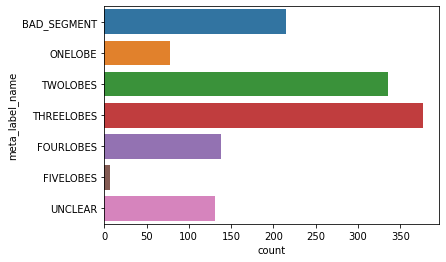

In [10]:
seaborn.countplot(data=df, y="meta_label_name")

# Plot annotations

In [11]:
im = AICSImage(df["meta_path"].iloc[0], reconstruct_mosaic=False)

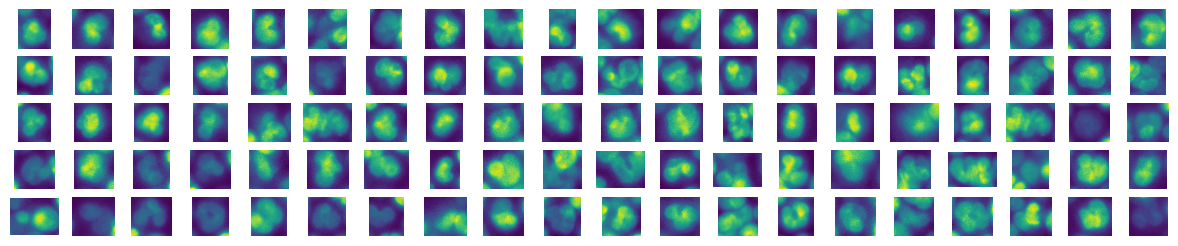

In [30]:
c = "BAD_SEGMENT"
fig, axes = plt.subplots(5, 20, figsize=(15, 3), dpi=100)
axes = axes.ravel()

for ax, (_, r) in zip(axes, df[df["meta_label_name"] == c].reset_index().sample(n=100).iterrows()):
    im.set_scene(r.meta_scene)
    pixels = numpy.max(im.get_image_data("ZXY", C=0), axis=0)
    minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])
    ax.imshow(pixels[minr:maxr, minc:maxc])
    ax.set_axis_off()

BAD_SEGMENT
ONELOBE
TWOLOBES
THREELOBES
FOURLOBES
FIVELOBES
UNCLEAR


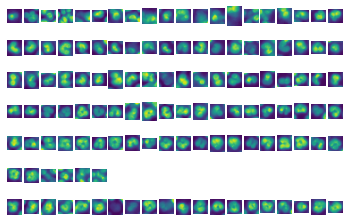

In [97]:
n = 20
fig, axes = plt.subplots(len(df["meta_label"].unique()), n)

for axes_row, (c, gdf) in zip(axes, df.groupby("meta_label_name")):
    print(c)
    n_ = min(n, len(gdf))
    
    i = 0
    for scene, sdf in gdf.iloc[:n_].groupby("meta_scene"):
        im.set_scene(scene)
        pixels = numpy.max(im.get_image_data("ZXY", C=0), axis=0)
        
        for idx, r in sdf.iterrows():
            minr, minc, maxr, maxc = int(r["meta_bbox_minr"]), int(r["meta_bbox_minc"]), int(r["meta_bbox_maxr"]), int(r["meta_bbox_maxc"])
            axes_row[i].imshow(pixels[minr:maxr, minc:maxc])
            i+=1
        
for ax in axes.ravel():
    ax.set_axis_off()